# **Training**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
import string
import wordcloud
import os
from langdetect import detect
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import words

In [ ]:
df = pd.read_csv("Preprocessed.csv")

In [8]:
from sklearn.model_selection import train_test_split

train_data ,test_data = train_test_split(df,test_size=0.2,random_state=10)

print('Training data: ',len(train_data))
print('Testing data: ',len(test_data))

Training data:  185659
Testing data:  46415


In [27]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
#tokenizer.word_index['text']


In [10]:
tokenizer.texts_to_matrix(train_data['text'])

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.]])

In [11]:
train_pad = tokenizer.texts_to_sequences(train_data['text'])
test_pad = tokenizer.texts_to_sequences(test_data['text'])

In [12]:
MAX_LENGTH = max(len(t) for t in df['text'])
MAX_LENGTH

45732

In [13]:
MAX_LENGTH = 200

In [14]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

42042

In [15]:
# Padding
train_data_padded = pad_sequences(train_pad, maxlen=MAX_LENGTH, padding='post')
test_data_padded = pad_sequences(test_pad, maxlen=MAX_LENGTH, padding='post')

In [16]:
train_data_padded.shape

(185659, 200)

In [17]:
train_data_padded

array([[ 383, 3159, 1059, ...,    0,    0,    0],
       [ 196, 6426,  196, ...,    0,    0,    0],
       [5521,   70,   99, ...,    0,    0,    0],
       ...,
       [1277,  559,    5, ...,    0,    0,    0],
       [   3,   44,  233, ...,    0,    0,    0],
       [ 445,   82,  212, ...,  500,    3,   23]], dtype=int32)

In [18]:
from sklearn.preprocessing import LabelEncoder

lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.fit_transform(test_data['class'])

In [19]:
#Read GloVe

path_GloVe = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
num_tokens = vocab_size
embedding_dim = 100
hits = 0
misses = 0
embedding_index = {}

In [20]:
# Read word vectors
with open(path_GloVe) as f:
    for line in f:
        word, coef = line.split(maxsplit=1)
        coef = np.fromstring(coef, "f", sep=" ")
        embedding_index[word] = coef
print("Found %s word vectors" % len(embedding_index))

# Assign word vectors to our dictionary/vocab
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print('Converted %d words (%d misses)' % (hits, misses))

Found 400000 word vectors
Converted 39821 words (2220 misses)


# **LSTM**

In [21]:
import tensorflow as tf
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential

In [22]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/SuicideDetect_LSTM.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [23]:
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dropout, GlobalMaxPooling1D, Dense

# Define the model
modelLSTM = Sequential()

# Add layers to the model
modelLSTM.add(Input(shape=(200,)))
embedding_layer = Embedding(vocab_size, embedding_dim, trainable=False)
modelLSTM.add(embedding_layer)

# Set the weights of the Embedding layer
embedding_layer.set_weights([embedding_matrix])

modelLSTM.add(LSTM(16, return_sequences=True))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(GlobalMaxPooling1D())

modelLSTM.add(Dense(16, activation='relu'))
modelLSTM.add(Dense(16, activation='relu'))

modelLSTM.add(Dense(1, activation='sigmoid'))

# Compile the model
modelLSTM.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
modelLSTM.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     4,204,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 16)        │         7,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,212,249 (16.07 MB)

 Trainable params: 8,049 (31.44 KB)

 Non-trainable params: 4,204,200 (16.04 MB)

In [24]:
historyLSTM=modelLSTM.fit(train_data_padded,
                  train_output,
                  validation_data=(test_data_padded,test_output),
                  epochs=20,
                  batch_size=32,
                  callbacks=[callback1])

Epoch 1/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.7831 - loss: 0.4682 - val_accuracy: 0.8914 - val_loss: 0.2803
Epoch 2/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.8921 - loss: 0.2718 - val_accuracy: 0.8976 - val_loss: 0.2625
Epoch 3/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0.9016 - loss: 0.2496 - val_accuracy: 0.9065 - val_loss: 0.2423
Epoch 4/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.9065 - loss: 0.2393 - val_accuracy: 0.9091 - val_loss: 0.2357
Epoch 5/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.9109 - loss: 0.2293 - val_accuracy: 0.9094 - val_loss: 0.2355
Epoch 6/20
1560/5802 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9123 - loss: 0.2200

KeyboardInterrupt: 

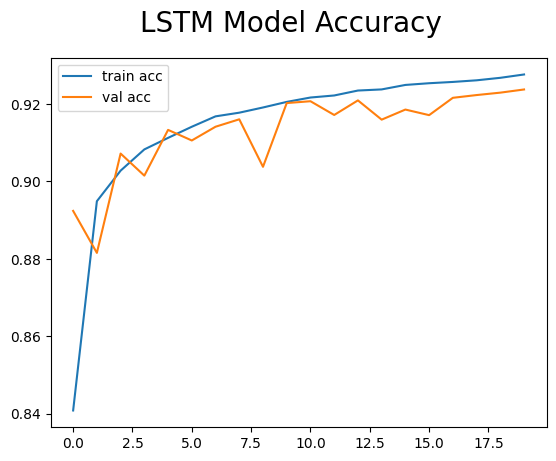

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(historyLSTM.history['accuracy'], scalex=True, scaley=True, label='train acc')
plt.plot(historyLSTM.history['val_accuracy'], scalex=True, scaley=True, label='val acc')
fig.suptitle('LSTM Model Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.legend()

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Confusion Matrix:


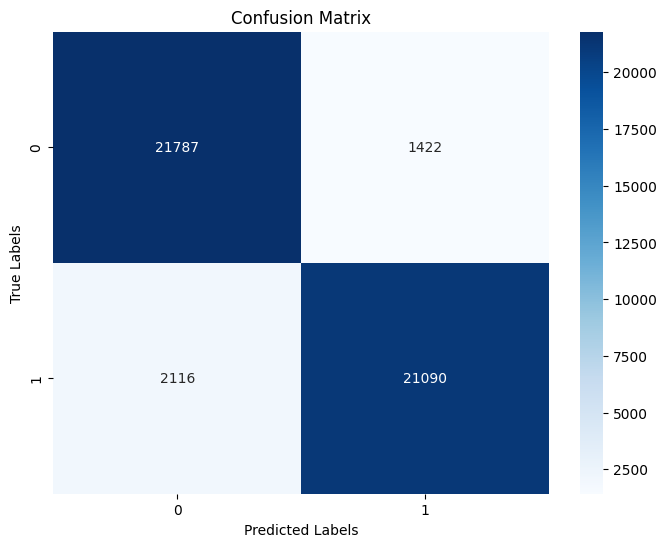

Accuracy: 0.9237746418183777
Precision: 0.9368336886993603
Recall: 0.9088166853399983
F1-score: 0.9226125377313094


In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test data
y_pred = modelLSTM.predict(test_data_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_output, y_pred_binary)

# Calculate accuracy
accuracy = accuracy_score(test_output, y_pred_binary)

# Calculate precision
precision = precision_score(test_output, y_pred_binary)

# Calculate recall
recall = recall_score(test_output, y_pred_binary)

# Calculate F1-score
f1 = f1_score(test_output, y_pred_binary)

print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
import spacy
nlp = spacy.load('en_core_web_sm')
# Function to remove extra whitespaces from each word in a list
def remove_whitespace(tokens):
    cleaned_tokens = [token.strip() for token in tokens]
    return cleaned_tokens

# Function to remove symbols and digits from each word in a list
def remove_symbols_digits(tokens):
    cleaned_tokens = [re.sub('[^a-zA-Z\s]', ' ', token) for token in tokens]
    return cleaned_tokens

# Function to remove special characters from each word in a list
def remove_special(tokens):
    cleaned_tokens = [token.replace("\r", " ").replace("\n", " ") for token in tokens]
    return cleaned_tokens
def lemmatize_tokens(tokens):
    # Join the tokens back into a sentence
    text = ' '.join(tokens)
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and return the lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens
# Preprocess the input text
input_text = "I wish I would've killed myself in the pastEvery new episode feels worse than the last. I can't go to bed because I don't want to wake up to another day full of procrastination and feeling like a failure. Currently on my finals but I can't get my ass up and study. Nothing will become of me and then I'll be stuck with a job I don't want in my life I don't want in my parent's house where I'm only ever yelled at and made clear to how much of a failure I am. Why can't I give my life to somebody who wants and deserves it?max_sequence_length = 200  # Max sequence length expected by the model"
#input_text = "I happy with my life"
# Tokenization
tokens = input_text.lower().split()

# Padding
tokens=remove_whitespace(tokens)
tokens=remove_symbols_digits(tokens)
tokens=remove_special(tokens)
tokens=lemmatize_tokens(tokens)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
encoded_tokens = tokenizer.texts_to_sequences([tokens])
padded_tokens = pad_sequences(encoded_tokens, maxlen=max_sequence_length)
# Perform prediction
y_pred = modelLSTM.predict(padded_tokens)
y_pred_binary = (y_pred > 0.5).astype(int)
if(y_pred_binary==1):
    print("Predicted class: Suicidal",y_pred)
else:
    print("Predicted class: Non-Suicidal",y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: Suicidal [[0.97945833]]
